# Network Models

Probably the easiest kinds of statistical models for us to think about are the *network models*. These types of models (like the name imples) describe the random processes which you'd find when you're only looking at one network. We can have models which assume all of the nodes connect to each other essentially randomly, models which assume that the nodes are in distinct *communities*, and many more.

The important realization to make about statistical models is that a model is *not* a network: it's the random process that *creates* a network. You can sample from a model a bunch of times, and because it's a random process, you'll end up with networks that look a little bit different each time -- but if you sampled a lot of networks and then averaged them, then you'd likely be able to get a reasonable ballpark estimation of what the model that they come from looks like.  

Let's pretend that we have a network, and the network is unweighted (meaning, we only have edges or not-edges) and undirected (meaning, edges connect nodes both ways). It'd have an adjacency matrix which consists of only 1's and 0's, because the only information we care about is whether there's an edge or not. The model that generated this network is pretty straightforward: there's just some universal probability that each node connects to each other node, and there are 10 nodes.

In [ ]:
import matplotlib.pyplot as plt
from graspologic.simulations import er_np
from graspologic.plot import binary_heatmap
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(figsize=(4,4))
n = 10
p = .5
A = er_np(n, p)
binary_heatmap(A, ax=ax, yticklabels=5, linewidths=1, linecolor="black", title="A small, simple network");

This small, simple network is one of many possible networks that we can generate with this model. Here are some more:

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for ax in axs.flat:
    A = er_np(n, p)
    hmap = binary_heatmap(A, ax=ax, yticklabels=5, linewidths=1, linecolor="black")
plt.suptitle("Three small, simple networks", fontsize=20)

One reasonable question to ask is how *many* possible networks we could make in this simple scenario? We've already made four, and it seems like there are more that this model could potentially generate.

As it turns out, "more" is a pretty massive understatement. To actually figure out the number, think about the first potential edge: there are two possibilities (edge or no edge), so you can generate two networks from a one-node model. Now, let's add an additional node. For each of the first two possibilities, there are two more -- so there are $2 \times 2 = 4$ total possible networks. Every node that we add doubles the number of networks - and since a network with $n$ nodes has $n \times n$ edges, the total number of possible networks ends up being $2^{n \times n} = 2^{n^2}$! So this ten-node model can generate $2^{10^2} = 2^{100}$ networks, which is, when you think carefully, an absurdly, ridiculously big number.

Throughout many of the succeeding sections, we will attempt to make the content accessible to readers with, and without, a more technical background. To this end, we have added sections with trailing asterisks (\*). While we believe these sections build technical depth, we don't think they are critical to understanding many of the core ideas for network machine learning. In contrast with unstarred sections, these sections will assume familiarity with more advanced mathematical and probability concepts.

## Foundation*

In [ ]:

import seaborn as sns
import numpy as np
from math import comb


n = np.arange(2, 51)
logAn = np.array([comb(ni, 2) for ni in n])*np.log10(2)

ax = sns.lineplot(x=n, y=logAn)
ax.set_title("")
ax.set_xlabel("Number of Nodes")
ax.set_ylabel("Number of Possible Graphs $|A_n|$ (log scale)")
ax.set_yticks([50, 100, 150, 200, 250, 300, 350])
ax.set_yticklabels(["$10^{{{pow:d}}}$".format(pow=d) for d in [50, 100, 150, 200, 250, 300, 350]])
ax;

So, now we know that we have probability distributions on networks, and a set $\mathcal A_n$ which defines all of the adjacency matrices that every probability distribution must assign a probability to. Now, just what is a network model? A **network model** is a set $\mathcal P$ of probability distributions on $\mathcal A_n$. Stated another way, we can describe $\mathcal P$ to be:
\begin{align*}
    \mathcal P &\subseteq \{\mathbb P: \mathbb P\textrm{ is a probability distribution on }\mathcal A_n\}
\end{align*}

In general, we will simplify $\mathcal P$ through something called *parametrization*. We define $\Theta$ to be the set of all possible parameters of the random network model, and $\theta \in \Theta$ is a particular parameter choice that governs the parameters of a specific network-valued random variaable $\mathbf A$. In this case, we will write $\mathcal P$ as the set:
\begin{align*}
    \mathcal P(\Theta) &= \left\{\mathbb P_\theta : \theta \in \Theta\right\}
\end{align*}
If $\mathbf A$ is a random network that follows a network model, we will write that $\mathbf A \sim \mathbb P_\theta$, for some choice $\theta$. We will often use the shorthand $\mathbf A \sim \mathbb P$.

If you are used to traditional univariate or multivariate statistical modelling, an extremely natural choice for when you have a discrete sample space (like $\mathcal A_n$, which is discrete because we can count it) would be to use a categorical model. In the categorical model, we would have a single parameter for all possible configurations of an $n$-node network; that is, $|\theta| = \left|\mathcal A_n\right| = 2^{\binom n 2}$. What is wrong with this model? The limitations are two-fold:
1. As we explained previously, when $n$ is just $15$, we would need over $10^{30}$ bits of storage just to define $\theta$. This amounts to more than $10^{8}$ zetabytes, which exceeds the storage capacity of *the entire world*.
2. With a single network observed (or really, any number of networks we could collect in the real world) we would never be able to get a reasonable estimate of $2^{\binom n 2}$ parameters for any reasonably non-trivial number of nodes $n$. For the case of one observed network $A$, an estimate of $\theta$ (referred to as $\hat\theta$) would simply be for $\hat\theta$ to have a $1$ in the entry corresponding to our observed network, and a $0$ everywhere else. Inferentially, this would imply that the network-valued random variable $\mathbf A$ which governs realizations $A$ is deterministic, even if this is not the case. Even if we collected potentially *many* observed networks, we would still (with very high probability) just get $\hat \theta$ as a series of point masses on the observed networks we see, and $0$s everywhere else. This would mean our parameter estimates $\hat\theta$ would not generalize to new observations at *all*, with high probability.

So, what are some more reasonable descriptions of $\mathcal P$? We explore some choices below. Particularly, we will be most interested in the *independent-edge* networks. These are the families of networks in which the generative procedure which governs the random networks assume that the edges of the network are generated *independently*. **Statistical Independence** is a property which greatly simplifies many of the modelling assumptions which are crucial for proper estimation and rigorous statistical inference, which we will learn more about in the later chapters.

### Equivalence Classes*

In all of the below models, we will explore the concept of the **probability equivalence class**, or an *equivalence class*, for short. The probability is a function which in general, describes how effective a particular observation can be described by a random variable $\mathbf A$ with parameters $\theta$, written $\mathbf A \sim F(\theta)$. The probability will be used to describe the probability $\mathbb P_\theta(\mathbf A)$ of observing the realization $A$ if the underlying random variable $\mathbf A$ has parameters $\theta$.  Why does this matter when it comes to equivalence classes? An equivalence class is a subset of the sample space $E \subseteq \mathcal A_n$, which has the following properties. Holding the parameters $\theta$ fixed:

1. If $A$ and $A'$ are members of the same equivalence class $E$ (written $A, A' \in E$), then $\mathbb P_\theta(A) = \mathbb P_\theta(A')$. 
2. If $A$ and $A''$ are members of different equivalence classes; that is, $A \in E$ and $A'' \in E'$ where $E, E'$ are equivalence classes, then $\mathbb P_\theta(A) \neq \mathbb P_\theta(A'')$.
3. Using points 1 and 2, we can establish that if $E$ and $E'$ are two different equivalence classes, then $E \cap E' = \varnothing$. That is, the equivalence classes are **mutually disjoint**.
4. We can use the preceding properties to deduce that given the sample space $\mathcal A_n$ and a probability function $\mathbb P_\theta$, we can define a partition of the sample space into equivalence classes $E_i$, where $i \in \mathcal I$ is an arbitrary indexing set. A **partition** of $\mathcal A_n$ is a sequence of sets which are mutually disjoint, and whose union is the whole space. That is, $\bigcup_{i \in \mathcal I} E_i = \mathcal A_n$. 

We will see more below about how the equivalence classes come into play with network models, and in a later section, we will see their relevance to the estimation of the parameters $\theta$.

(representations:whyuse:networkmodels:iern)=
### Independent-Edge Random Networks*

The below models are all special families of something called **independent-edge random networks**. An independent-edge random network is a network-valued random variable, in which the collection of edges are all independent. In words, this means that for every adjacency $\mathbf a_{ij}$ of the network-valued random variable $\mathbf A$, that $\mathbf a_{ij}$ is independent of $\mathbf a_{i'j'}$, any time that $(i,j) \neq (i',j')$. When the networks are simple, the easiest thing to do is to assume that each edge $(i,j)$ is connected with some probability (which might be different for each edge) $p_{ij}$. We use the $ij$ subscript to denote that this probability is not necessarily the same for each edge. This simple model can be described as $\mathbf a_{ij}$ has the distribution $Bern(p_{ij})$, for every $j > i$, and is independent of every other edge in $\mathbf A$. We only look at the entries $j > i$, since our networks are simple. This means that knowing a realization of $\mathbf a_{ij}$ also gives us the realizaaion of $\mathbf a_{ji}$ (and thus $\mathbf a_{ji}$ is a *deterministic* function of $\mathbf a_{ij}$). Further, we know that the random network is loopless, which means that every $\mathbf a_{ii} = 0$. We will call the matrix $P = (p_{ij})$ the **probability matrix** of the network-valued random variable $\mathbf A$. In general, we will see a common theme for the probabilities of a realization $A$ of a network-valued random variable $\mathbf A$, which is that it will greatly simplify our computation. Remember that if $\mathbf x$ and $\mathbf y$ are binary variables which are independent, that $\mathbb P(\mathbf x = x, \mathbf y = y) = \mathbb P(\mathbf x = x) \mathbb P(\mathbf y = y)$. Using this fact:

\begin{align*}
\mathbb P(\mathbf A = A) &= \mathbb P(\mathbf a_{11} = a_{11}, \mathbf a_{12} = a_{12}, ..., \mathbf a_{nn} = a_{nn}) \\
    &= \mathbb P(\mathbf a_{ij} = a_{ij} \text{ for all }j > i) \\
    &= \prod_{j > i}\mathbb P(\mathbf a_{ij} = a_{ij}), \;\;\;\;\textrm{Independence Assumption}
\end{align*}
Next, we will use the fact that if a random variable $\mathbf a_{ij}$ has the Bernoulli distribution with probability $p_{ij}$, that $\mathbb P(\mathbf a_{ij} = a_{ij}) = p_{ij}^{a_{ij}}(1 - p_{ij})^{1 - p_{ij}}$:
\begin{align*}
    \mathbb P_\theta(A) &= \prod_{j > i}p_{ij}^{a_{ij}}(1 - p_{ij})^{1 - p_{ij}}
\end{align*}

Now that we've specified a probability and a very generalizable model, we've learned the full story behind network models and are ready to skip to estimating parameters, right? *Wrong!* Unfortunately, if we tried too estimate anything about each $p_{ij}$ individually, we would obtain that $p_{ij} = a_{ij}$ if we only have one realization $A$. Even if we had many realizations of $\mathbf A$, this still would not be very interesting, since we have a *lot* of $p_{ij}$s to estimate, and we've ignored any sort of structural model that might give us deeper insight into $\mathbf A$. In the below sections, we will learn successively less restrictive (and hence, *more expressive*) assumptions about $p_{ij}$s, which will allow us to convey fairly complex random networks, but *still* enable us with plenty of intteresting things to learn about later on.

## Erd&ouml;s-R&eacute;nyi (ER)

We will start our description with the simplest random network model. Consider a social network, with $50$ students. Our network will have $50$ nodes, where each node represents a single student in the network. Edges in the social network represent whether or not a pair of students are friends. What is the simplest way we could describe whether two people are friends?

In this case, we have a yes or no question: are a pair of people friends, or are they not friends? In this case, the simplest possible thing to do would be to say, for any two students in our network, there is some probability (which we will call $p$) that describes how likely they are to be friends. In the below example, for the sake of argument, we will let $p=0.3$. What does a realization from this network look like?

/Users/eric/.virtualenvs/graph-book/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


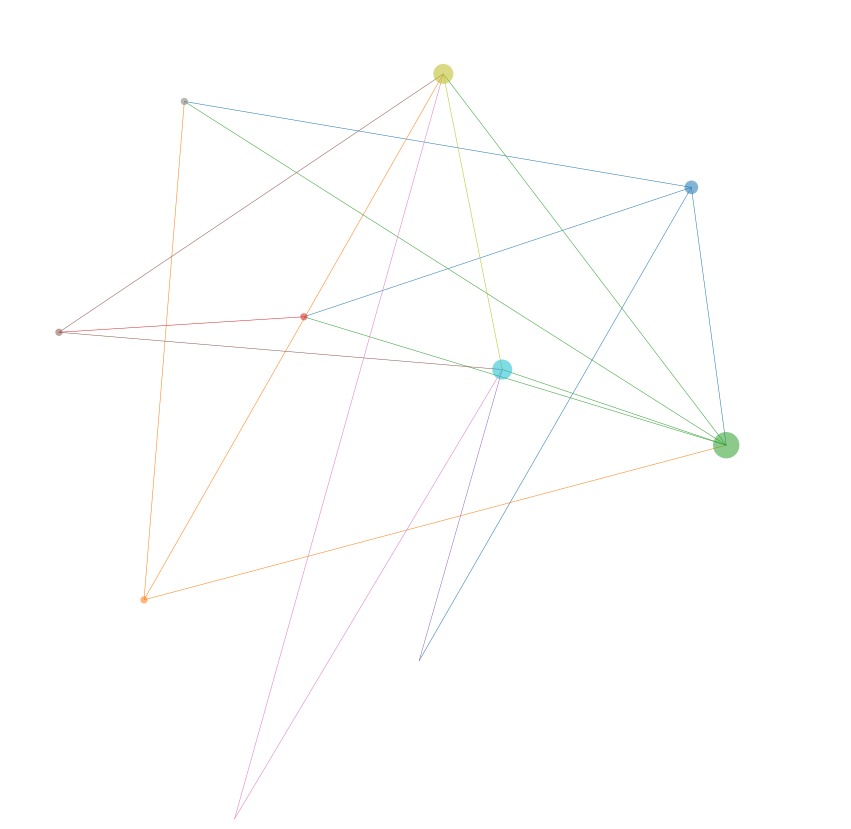

In [1]:
from graspologic.layouts import layout_umap, show_graph
from graspologic.simulations import er_np
import networkx as nx
import seaborn as sns

n = 50  # network with 50 nodes
p = 0.3  # probability of an edge existing is .3

# sample a single simple adjacency matrix from ER(50, .3)
A = er_np(n=n, p=p, directed=False, loops=False)

g = nx.convert_matrix.from_numpy_matrix(A)
di = {}
for i in range(len(list(g.nodes))):
    di[list(g.nodes)[i]] = str(list(g.nodes)[i])
g = nx.relabel_nodes(g, di)

tupl = layout_umap(g)

nodes = list(g.nodes)
colors = sns.color_palette(n_colors = g.number_of_nodes())
node_to_color = dict(zip(nodes, colors))

show_graph(tupl[0], tupl[1], node_to_color, edge_alpha=1)

Using this example, now let's get down to business. This simple random network model is called the Erd&ouml;s R&eacute;nyi (ER) model<sup>1</sup>. The Erd&ouml;s R&eacute;nyi model formalizes this relatively simple situation with a single parameter and an $iid$ assumption:

| Parameter | Space | Description |
| --- | --- | --- |
| $p$ | $[0, 1]$ | Probability that an edge exists between a pair of nodes, which is identical for all pairs of nodes |

From here on out, when we talk about an Erd&ouml;s R&eacute;nyi random variable, we will simply call it an ER network. In an ER network, each pair of nodes is connected with probability $p$, and therefore not connected with probability $1-p$. Statistically, we say that for each edge $\mathbf{a}_{ij}$, that $\mathbf{a}_{ij}$ is sampled independently and identically from a *Bernoulli* distribution with probability $p$. The word "independent" means that edges in the network occurring or not occurring do not affect one another. For instance, this means that if we knew a student named Alice was friends with Bob, and Alice was also friends with Chadwick, that we do not learn any information about whether Bob is friends with Chadwick. The word "identical" means that every edge in the network has the same probability $p$ of being connected. If Alice and Bob are friends with probability $p$, then Alice and Chadwick are friends with probability $p$, too. We assume here that the networks are undirected, which means that if an edge $\mathbf a_{ij}$ exists from node $i$ to $j$, then the edge $\mathbf a_{ji}$ also exists from node $j$ to node $i$. We also assume that the networks are loopless, which means that no edges $\mathbf a_{ii}$ can go from node $i$ to itself. If $\mathbf A$ is the adjacency matrix for an ER network with probability $p$, we write that $\mathbf A \sim ER_n(p)$.

### Practical Utility

In practice, the ER model seems like it might be a little too simple to be useful. Why would it ever be useful to think that the best we can do to describe our network is to say that connections exist with some probability? Does this miss a *lot* of useful questions we might want to answer? Fortunately, there are a number of ways in which the simplicity of the ER model is useful. Given a probability and a number of nodes, we can easily describe the properties we would expect to see in a network if that network were ER. For instance, we know how many edges on average the nodes of an ER nework should have. We can reverse this idea, too: given a network we think might *not* be ER, we could check whether it's different in some way from a network which is ER. For instance, if we see that half the nodes have a ton of edges (meaning, they have a high degree), and half don't, we should probably use a more complicated model than an Erdos-Renyi. If this is the case, we might look for other models that could describe our network which are more complex.


```{admonition} Working Out the Expected Degree in an Erd&ouml;s-R&eacute;nyi Network
Suppose that $\mathbf A$ is a simple network which is random. The network has $n$ nodes $\mathcal V = (v_i)_{i = 1}^n$. Recall that the in a simple network, the node degree is $deg(v_i) = \sum_{j = 1}^n \mathbf a_{ij}$. What is the expected degree of a node $v_i$ of a random network $\mathbf A$ which is Erd&ouml;s-R&eacute;nyi?

To describe this, we will compute the expectated value of the degree $deg(v_i)$, written $\mathbb E\left[deg(v_i)\right]$. Let's see what happens:
\begin{align*}
    \mathbb E\left[deg(v_i)\right] &= \mathbb E\left[\sum_{j = 1}^n \mathbf a_{ij}\right] \\
    &= \sum_{j = 1}^n \mathbb E[\mathbf a_{ij}]
\end{align*}
We use the *linearity of expectation* in the line above, which means that the expectation of a sum with a finite number of terms being summed over ($n$, in this case) is the sum of the expectations. Finally, by definition, all of the edges $A_{ij}$ have the same distribution: $Bern(p)$. The expected value of a random quantity which takes a Bernoulli distribution is just the probability $p$. This means every term $\mathbb E[\mathbf a_{ij}] = p$. Therefore:
\begin{align*}
    \mathbb E\left[deg(v_i)\right] &= \sum_{j = 1}^n p = n\cdot p
\end{align*}
Since all of the $n$ terms being summed have the same expected value. This holds for *every* node $v_i$, which means that the expected degree of all nodes is an undirected ER network is the same number, $n \cdot p$.
```

<!-- The ER model is also useful for the development of new computational techniques to use on random networks. This is because even if the "best" model for a network is something much more complex, we can still calculate an edge probability $p$ for the network without needing any information but the adjacency matrix. Consider, for instance, a case where we design a new algorithm for a social network, and we want to know how much more RAM we might need as the social network grows. We might want to investigate how the algorithm scales to networks with different numbers of people and different connection probabilities that might be realistic as our social network expands in popularity. Examining how the algorithm operates on ER networks with different values of $n$ and $p$ might be helpful. This is an especially common approach when people deal with networks that are said to be *sparse*. A **sparse network** is a network in which the number of edges is much less than the total possible number of edges. This contrasts with a **dense network**, which is a network in which the number of edges is close to the maximum number of possible edges. In the case of an $ER_{n}(p)$ network, the network is sparse when $p$ is small (closer to $0$), and dense when $p$ is large (closer to $1$). -->


In the next code block, we are going to sample a single ER network with $50$ nodes and an edge probability $p$ of $0.3$:

In [2]:
from graspologic.plot import heatmap
from graspologic.simulations import er_np

n = 50  # network with 50 nodes
p = 0.3  # probability of an edge existing is .3

# sample a single simple adjacency matrix from ER(50, .3)
A = er_np(n=n, p=p, directed=False, loops=False)

# and plot it
binary_heatmap(A, title="$ER_{50}(0.3)$ Simulation")
plt.show()

NameError: name 'binary_heatmap' is not defined

Above, we visualize the network using a heatmap. The dark squares indicate that an edge exists between a pair of nodes, and white squares indicate that an edge does not exist between a pair of nodes.

Next, let's see what happens when we use a higher edge probability, like $p=0.7$:

In [ ]:
p = 0.7  # network has an edge probability of 0.7

# sample a single adjacency matrix from ER(50, 0.7)
A = er_np(n=n, p=p, directed=False, loops=False)

# and plot it
binary_heatmap(A, title="$ER_{50}(0.7)$ Simulation")
plt.show()

As the edge probability increases, the sampled adjacency matrix tends to indicate that there are more connections in the network. This is because there is a higher chance of an edge existing when $p$ is larger.


### Probability*

What is the probability for realizations of Erd&ouml;s-R&eacute;nyi networks? Remember that for Independent-edge graphs, that the probability can be written:

\begin{align*}
    \mathbb P_{\theta}(A) &= \prod_{j > i} \mathbb P_\theta(\mathbf{a}_{ij} = a_{ij})
\end{align*}

Next, we recall that by assumption of the ER model, that the probability matrix $P = (p)$, or that $p_{ij} = p$ for all $i,j$. Therefore:

\begin{align*}
    \mathbb P_\theta(A) &= \prod_{j > i} p^{a_{ij}}(1 - p)^{1 - a_{ij}} \\
    &= p^{\sum_{j > i} a_{ij}} \cdot (1 - p)^{\binom{n}{2} - \sum_{j > i}a_{ij}} \\
    &= p^{m} \cdot (1 - p)^{\binom{n}{2} - m}
\end{align*}

This means that the probability $\mathbb P_\theta(A)$ is a function *only* of the number of edges $m = \sum_{j > i}a_{ij}$ in the network represented by adjacency matrix $A$. The equivalence class on the Erd&ouml;s-R&eacute;nyi networks are the sets:

\begin{align*}
    E_{i} &= \left\{A \in \mathcal A_n : m = i\right\}
\end{align*}

where $i$ index from $0$ (the minimum number of edges possible) all the way up to $n^2$ (the maximum number of edges possible). All of the relationships for equivalence classes discussed above apply to the sets $E_i$.

## Stochastic Block Model (SBM)

Let's imagine that we have $100$ students, each of whom can go to one of two possible schools: school one or school two. Our network has $100$ nodes, and each node represents a single student. The edges of this network represent whether a pair of students are friends. Intuitively, if two students go to the same school, it might make sense to say that they have a higher chance of being friends than if they do not go to the same school. If we were to try to characterize this network using an ER network, we would run into a problem: we have no way to capture the fact that which school students attend has an impact on who they might be friends with. Intuitively, there must be a better way!

The Stochastic Block Model, or SBM, captures this idea by assigning each of the $n$ nodes in the network to one of $K$ communities. A **community** is a group of nodes within the network. In our example case, the communities would represent the schools that students are able to attend in our network. In an SBM, instead of describing all pairs of nodes with a fixed probability like with the ER model, we instead describe properties that hold for edges between *pairs of communities*. In this sense, for a given school, we could think of the network that describes that school's students as ER.

### *A Priori* Stochastic Block Model

The *a priori* SBM is an SBM in which we know ahead of time (*a priori*) which nodes are in which communities. Here, we will use the variable $K$ to denote the maximum number of different communities. The ordering of the communities does not matter; the community we call $1$ versus $2$ versus $K$ is largely a symbolic distinction (the only thing that matters is that they are *different*). The *a priori* SBM has the following parameter:

| Parameter | Space | Description |
| --- | --- | --- |
| $B$ | [0,1]$^{K \times K}$ | The block matrix, which assigns edge probabilities for pairs of communities |


To describe the *a priori* SBM, we will use a latent variable model. To do so, we will assume there is some vector-valued random variable, $\vec{\pmb \tau}$, which we will call the **node assignment vector**. This random variable takes values $\vec\tau$ which are in the space $\{1,...,K\}^n$. That means that each element of a realization $\vec\tau$ takes one of $K$ possible values. Each node receives a community assignment, so we say that $i$ goes from $1$ to $n$. Stated another way, each node $i$ of our network receives an assignment $\tau_i$ to one of the $K$ communities. This model is called the *a priori* SBM because we use it when we have a realization $\vec\tau$ that we know ahead of time. In our social network example, for instance, $\tau_i$ would reflect that each student can attend one of two possible schools. For a single node $i$ that is in community $\ell$, where $\ell \in \{1, ..., K\}$, we write that $\tau_i = \ell$. 

Next, let's discuss the matrix $B$, which is known as the **block matrix** of the SBM. We write down that $B \in [0, 1]^{K \times K}$, which means that the block matrix is a matrix with $K$ rows and $K$ columns. If we have a pair of nodes and know which of the $K$ communities each node is from, the block matrix tells us the probability that those two nodes are connected. If our networks are simple, the matrix $B$ is also symmetric, which means that if $b_{kk'} = p$ where $p$ is a probability, that $b_{k'k} = p$, too. The requirement of $B$ to be symmetric exists *only* if we are dealing with simple networks, since they are undirected; if we relax the requirement of undirectedness (and allow directed networks) $B$ no longer need be symmetric.

Finally, let's think about how to write down the generative model for the *a priori* SBM. Intuitionally what we want to reflect is, if we know that node $i$ is in community $\ell$ and node $j$ is in community $k$, that the $(\ell, k)$ entry of the block matrix is the probability that $i$ and $j$ are connected. We say that given  $\tau_i = k'$ and $\tau_j = k$, $\mathbf a_{ij}$ is sampled independently from a $Bern(b_{k' k})$ distribution for all $j > i$. Note that the adjacencies $\mathbf a_{ij}$ are not *necessarily* identically distributed, because the probability depends on the community of edge $(i,j)$. If $\mathbf A$ is an *a priori* SBM network with parameter $B$, and $\vec{\tau}$ is a realization of the node-assignment vector, we write that $\mathbf A \sim SBM_{n,\vec \tau}(B)$.

### Code Examples

We just covered a lot of intuition! This intuition will come in handy later, but let's take a break from the theory by working through an example. Say we have $300$ students, and we know that each student goes to one of two possible schools. We will begin by thinking about the *a priori* SBM, since it's a little more straightforward to generate samples. Remember the *a priori* SBM is the SBM where already have a realization of $\vec{\pmb \tau}$ ahead of time. We don't really care too much about the ordering of the students for now, so let's just assume that the first $150$ students all go to the first school, and the second $150$ students all go to the second school. 

```{admonition} Thought Exercise

Before you read on, try to think to yourself about what the node-assignment vector $\vec \tau$ looks like.
```

Next, let's plot what $\vec \tau$ and $B$ look like:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib

def plot_tau(tau, title="", xlab="Node"):
    cmap = matplotlib.colors.ListedColormap(["skyblue", 'blue'])
    fig, ax = plt.subplots(figsize=(10,2))
    with sns.plotting_context("talk", font_scale=1):
        ax = sns.heatmap((tau - 1).reshape((1,tau.shape[0])), cmap=cmap,
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False)
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        cbar.set_ticks([0.25, .75])
        cbar.set_ticklabels(['School 1', 'School 2'])
        ax.set(xlabel=xlab)
        ax.set_xticks([.5,149.5,299.5])
        ax.set_xticklabels(["1", "150", "300"])
        cbar.ax.set_frame_on(True)
    return

n = 300  # number of students

# tau is a column vector of 150 1s followed by 50 2s
# this vector gives the school each of the 300 students are from
tau = np.vstack((np.ones((int(n/2),1)), np.full((int(n/2),1), 2)))

plot_tau(tau, title="Tau, Node Assignment Vector",
        xlab="Student")

So as we can see, the first $150$ students are from the first school, and the second $150$ students are from second school.

Let's assume that the students from the first school are better friends in general than the students from the second school, so we'll say that the probability of two students who both go to the first school being friends is $0.5$, and the probability of two students who both go to school $2$ being friends is $0.3$. Finally, let's assume that if one student goes to the first school and the other student goes to school $2$, that the probability that they are friends is $0.2$.
 
```{admonition} Thought Exercise

Before you read on, try to think to yourself about what the block matrix $B$ looks like.
```

 Next, let's look at the block matrix $B$: 

In [ ]:
K = 2  # 2 communities in total
# construct the block matrix B as described above
B = np.zeros((K, K))
B[0,0] = .5
B[0,1] = B[1,0] = .2
B[1,1] = .3

In [ ]:

def plot_block(X, title="", blockname="School", blocktix=[0.5, 1.5],
               blocklabs=["School 1", "School 2"]):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    with sns.plotting_context("talk", font_scale=1):
        ax = sns.heatmap(X, cmap="Purples",
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False, vmin=0, vmax=1)
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        ax.set(ylabel=blockname, xlabel=blockname)
        ax.set_yticks(blocktix)
        ax.set_yticklabels(blocklabs)
        ax.set_xticks(blocktix)
        ax.set_xticklabels(blocklabs)
        cbar.ax.set_frame_on(True)
    return

plot_block(B, title="Block Matrix")
plt.show()

As we can see, the matrix $B$ is a symmetric block matrix, since our network is undirected. Finally, let's sample a single network from the SBM with parameters $\vec \tau$ and $B$:

In [ ]:
from graspologic.simulations import sbm
from graspologic.plot import adjplot
import pandas as pd

# sample a graph from SBM_{300}(tau, B)
A = sbm(n=[int(n/2), int(n/2)], p=B, directed=False, loops=False)
meta = pd.DataFrame(
    data = {"School": tau.reshape((n)).astype(int)}
)

ax=adjplot(A, meta=meta, color="School", palette="Blues")

The above network shows students, ordered by the school they are in (first school and school 2, respectively). As we can see in the above network, people from the first school are more connected than people from school $2$. Also, the connections between people from different schools appear to be a bit *more sparse* (fewer edges) than connections betwen schools. The above heatmap can be described as **modular**: in that it has clear communities. Remember that the connections for each node are indicated by a single row, or a single column, of the adjacency matrix. The first half of the rows have strong connections with the first half of the columns, which indicates that the first half of students tend to be better friends with other students in the first half. We can duplicate this argument for the second half of students ot see that it seems reasonable to conclude that there are two communities of students here.

Something easy to mistake about the SBM is that the SBM will *not always* have the obvious modular structure we can see above when we look at a heatmap. Rather, this modular structure is *only* made obvious because the students are ordered according to the school in which they are in. What do you think will happen if we look at the students in a random order? Do you think it will be obvious that the network will have a modular structure?

The answer is: *No!* Let's see what happens when we reorder the nodes from the network into a random order:

In [ ]:
import numpy as np

# generate a reordering of the n nodes
vtx_perm = np.random.choice(n, size=n, replace=False)

meta = pd.DataFrame(
    data = {"School": tau[vtx_perm].reshape((n)).astype(int)}
)

# same adjacency matrix (up to reorder of the nodes)

ax=adjplot(A[tuple([vtx_perm])] [:,vtx_perm], meta=meta, color="School", palette="Blues")

Notice that now, the students are *not* organized according to school. We can see this by looking at the school assignment vector, shown at the left and top, of the network. It becomes pretty tough to figure out whether there are communities in our network just by looking at an adjacency matrix, unless you are looking at a network in which the nodes are *already arranged* in an order which respects the community structure. 

In practice, this means that if you know ahead of time what natural groupings of the nodes might be (such knowing which school each student goes to) by way of your node attributes, you can visualize your data according to that grouping. If you don't know anything about natural groupings of nodes, however, we are left with the problem of *estimating community structure*. A later method, called the *spectral embedding*, will be paired with clustering techniques to allow us to estimate node assignment vectors.

#### Probability*

What does the probability for the *a priori* SBM look like? Fortunately, since $\vec \tau$ is a *parameter* of the *a priori* SBM, the probability is a bit simpler than for the *a posteriori* SBM. This is because the *a posteriori* SBM requires an integration over potential realizations of $\vec{\pmb \tau}$, whereas the *a priori* SBM does not, since we already know that $\vec{\pmb \tau}$ was realized as $\vec\tau$.

Putting these steps together gives us that:
\begin{align*}
\mathbb P_\theta(A) &= \mathbb P_{\theta}(\mathbf A = A | \vec{\pmb \tau} = \vec\tau) \\
&= \prod_{j > i} \mathbb P_\theta(\mathbf a_{ij} = a_{ij} | \vec{\pmb \tau} = \vec\tau),\;\;\;\;\textrm{Independence Assumption}
\end{align*}

Next, for the *a priori* SBM, we know that each edge $\mathbf a_{ij}$ only *actually* depends on the community assignments of nodes $i$ and $j$, so we know that $\mathbb P_{\theta}(\mathbf a_{ij} = a_{ij} | \vec{\pmb \tau} = \vec\tau) = \mathbb P(\mathbf a_{ij} = a_{ij} | \tau_i = k', \tau_j = k)$, where $k$ and $k'$ are any of the $K$ possible communities. This is because the community assignments of nodes that are not nodes $i$ and $j$ do not matter for edge $ij$, due to the independence assumption. 

Next, let's think about the probability matrix $P = (p_{ij})$ for the *a priori* SBM. We know that, given that $\tau_i = k'$ and $\tau_j = k$,  each adjacency $\mathbf a_{ij}$ is sampled independently and identically from a $Bern(b_{k',k})$ distribution. This means that $p_{ij} = b_{k',k}$. Completing our analysis from above:
\begin{align*}
    \mathbb P_\theta(A) &= \prod_{j > i} b_{k'k}^{a_{ij}}(1 - b_{k'k})^{1 - a_{ij}} \\
    &= \prod_{k,k' \in [K]}b_{k'k}^{m_{k'k}}(1 - b_{k'k})^{n_{k'k} - m_{k'k}}
\end{align*}

Where $n_{k' k}$ denotes the total number of edges possible between nodes assigned to community $k'$ and nodes assigned to community $k$. That is, $n_{k' k} = \sum_{j > i} \mathbb 1_{\tau_i = k'}\mathbb 1_{\tau_j = k}$. Further, we will use $m_{k' k}$ to denote the total number of edges observed between these two communities. That is, $m_{k' k} = \sum_{j > i}\mathbb 1_{\tau_i = k'}\mathbb 1_{\tau_j = k}a_{ij}$. Note that for a single $(k',k)$ community pair, that the probability is analogous to the probability of a realization of an ER random variable.

<!--- We can formalize this a bit more explicitly. If we let $A^{\ell k}$ be defined as the subgraph *induced* by the edges incident nodes in community $\ell$ and those in community $k$, then we can say that $A^{\ell k}$ is a directed ER random network, --->

Like the ER model, there are again equivalence classes of the sample space $\mathcal A_n$ in terms of their probability. For a two-community setting, with $\vec \tau$ and $B$ given, the equivalence classes are the sets:
\begin{align*}
    E_{a,b,c}(\vec \tau, B) &= \left\{A \in \mathcal A_n : m_{11} = a, m_{21}=m_{12} = b, m_{22} = c\right\}
\end{align*}

The number of equivalence classes possible scales with the number of communities, and the manner in which nodes are assigned to communities (particularly, the number of nodes in each community). 


### *A Posteriori* Stochastic Block Model

In the *a posteriori* Stochastic Block Model (SBM), we consider that node assignment to one of $K$ communities is a random variable, that we *don't* know already like te *a priori* SBM. We're going to see a funky word come up, that you're probably not familiar with, the **$K$ probability simplex**. What the heck is a probability simplex?

The intuition for a simplex is probably something you're very familiar with, but just haven't seen a word describe. Let's say I have a vector, $\vec\pi = (\pi_k)_{k \in [K]}$, which has a total of $K$ elements. $\vec\pi$ will be a vector, which indicates the *probability* that a given node is assigned to each of our $K$ communities, so we need to impose some additional constraints. Symbolically, we would say that, for all $i$, and for all $k$:
\begin{align*}
    \pi_k = \mathbb P(\pmb\tau_i = k)
\end{align*}
The $\vec \pi$ we're going to use has a very special property: all of its elements are non-negative: for all $\pi_k$, $\pi_k \geq 0$. This makes sense since $\pi_k$ is being used to represent the probability of a node $i$ being in group $k$, so it certainly can't be negative. Further, there's another thing that we want our $\vec\pi$ to have: in order for each element $\pi_k$ to indicate the probability of something to be assigned to $k$, we need all of the $\pi_k$s to sum up to one. This is because of something called the Law of Total Probability. If we have $K$ total values that $\pmb \tau_i$ could take, then it is the case that:
\begin{align*}
    \sum_{k=1}^K \mathbb P(\pmb \tau_i = k) = \sum_{k = 1}^K \pi_k = 1
\end{align*}
So, back to our question: how does a probability simplex fit in? Well, the $K$ probability simplex describes all of the possible values that our vector $\vec\pi$ could take! In symbols, the $K$ probability simplex is:
\begin{align*}
\left\{\vec\pi : \text{for all $k$ }\pi_k \geq 0, \sum_{k = 1}^K \pi_k = 1 \right\}
\end{align*}
So the $K$ probability simplex is just the space for all possible vectors which could indicate assignment probabilities to one of $K$ communities. 

What does the probability simplex look like yy? Below, we take a look at the $2$-probability simplex (2-d $\vec\pi$s) and the $3$-probability simplex (3-dimensional $\vec\pi$s):

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig=plt.figure(figsize=plt.figaspect(.5))
fig.suptitle("Probability Simplexes")
ax=fig.add_subplot(1,2,1)
x=[1,0]
y=[0,1]
ax.plot(x,y)
ax.set_xticks([0,.5,1])
ax.set_yticks([0,.5,1])
ax.set_xlabel("$\pi_1$")
ax.set_ylabel("$\pi_2$")
ax.set_title("2-probability simplex")

ax=fig.add_subplot(1,2,2,projection='3d')
x = [1,0,0]
y = [0,1,0]
z = [0,0,1]
verts = [list(zip(x,y,z))]
ax.add_collection3d(Poly3DCollection(verts, alpha=.6))
ax.view_init(elev=20,azim=10)
ax.set_xticks([0,.5,1])
ax.set_yticks([0,.5,1])
ax.set_zticks([0,.5,1])
ax.set_xlabel("$\pi_1$")
ax.set_ylabel("$\pi_2$")
h=ax.set_zlabel("$\pi_3$", rotation=0)
ax.set_title("3-probability simplex")
plt.show()

The values of $\vec\pi = (\pi)$ that are in the $K$-probability simplex are indicated by the shaded region of each figure. This comprises the $(\pi_1, \pi_2)$ pairs that fall along a diagonal line from $(0,1)$ to $(1,0)$ for the $2$-simplex, and the $(\pi_1, \pi_2, \pi_3)$ tuples that fall on the surface of the triangular shape above with nodes at $(1,0,0)$, $(0,1,0)$, and $(0,0,1)$.

This model has the following parameters:

| Parameter | Space | Description |
| --- | --- | --- |
| $\vec \pi$ | the $K$ probability simplex | The probability of a node being assigned to community $K$ |
| $B$ | [0,1]$^{K \times K}$ | The block matrix, which assigns edge probabilities for pairs of communities |

The *a posteriori* SBM is a bit more complicated than the *a priori* SBM. We will think about the *a posteriori* SBM as a variation of the *a priori* SBM, where instead of the node-assignment vector being treated as a vector-valued random variable which takes a known fixed value, we will treat it as *unknown*. $\vec{\pmb \tau}$ is still a *latent variable* like it was before. In this case, $\vec{\pmb \tau}$ takes values in the space $\{1,...,K\}^n$. This means that for a given realization of $\vec{\pmb \tau}$, denoted by $\vec \tau$, that for each of the $n$ nodes in the network, we suppose that an integer value between $1$ and $K$ indicates which community a node is from. Statistically, we write that the node assignment for node $i$, denoted by $\pmb \tau_i$, is sampled independently and identically from $Categorical(\vec \pi)$. Stated another way, the vector $\vec\pi$ indicates the probability $\pi_k$ of assignment to each community $k$ in the network.

The matrix $B$ behaves exactly the same as it did with the *a posteriori* SBM. Finally, let's think about how to write down the generative model in the *a posteriori* SBM. The model for the *a posteriori* SBM is, in fact, nearly the same as for the *a priori* SBM: we still say that given $\tau_i = k'$ and $\tau_j = k$, that $\mathbf a_{ij}$ are independent $Bern(b_{k'k})$. Here, however, we also describe that $\pmb \tau_i$ are sampled independent and identically from $Categorical(\vec\pi)$, as we learned above. If $\mathbf A$ is the adjacency matrix for an *a posteriori* SBM network with parameters $\vec \pi$ and $B$, we write that $\mathbf A \sim SBM_n(\vec \pi, B)$. 

#### Probability*

What does the probability for the *a posteriori* SBM look like? In this case, $\theta = (\vec \pi, B)$ are the parameters for the model, so the probability for a realization $A$ of $\mathbf A$ is:
\begin{align*}
\mathbb P_\theta(A) &= \mathbb P_\theta(\mathbf A = A)
\end{align*}
Next, we use the fact that the probability that $\mathbf A = A$ is, in fact, the *integration* (over realizations of $\vec{\pmb \tau}$) of the joint $(\mathbf A, \vec{\pmb \tau})$. In this case, we will let $\mathcal T = \{1,...,K\}^n$ be the space of all possible realizations that $\vec{\pmb \tau}$ could take:
\begin{align}
\mathbb P_\theta(A)&= \sum_{\vec \tau \in \mathcal T} \mathbb P_\theta(\mathbf A = A, \vec{\pmb \tau} = \vec \tau) 
\end{align}
Next, remember that by definition of a conditional probability for a random variable $\mathbf x$ taking value $x$ conditioned on random variable $\mathbf y$ taking the value $y$, that $\mathbb P(\mathbf x = x | \mathbf y = y) = \frac{\mathbb P(\mathbf x = x, \mathbf y = y)}{\mathbb P(\mathbf y = y)}$. Note that by multiplying through by $\mathbf P(\mathbf y = y)$, we can see that $\mathbb P(\mathbf x = x, \mathbf y = y) = \mathbb P(\mathbf x = x| \mathbf y = y)\mathbb P(\mathbf y = y)$. Using this logic for $\mathbf A$ and $\vec{\pmb \tau}$:
\begin{align*}
\mathbb P_\theta(A) &=\sum_{\vec \tau \in \mathcal T} \mathbb P_\theta(\mathbf A = A| \vec{\pmb \tau} = \vec \tau)\mathbb P(\vec{\pmb \tau} = \vec \tau)
\end{align*}
Intuitively, for each term in the sum, we are treating $\vec{\pmb \tau}$ as taking a fixed value, $\vec\tau$, to evaluate this probability statement. 

We will start by describing $\mathbb P(\vec{\pmb \tau} = \vec\tau)$. Remember that for $\vec{\pmb \tau}$, that each entry $\pmb \tau_i$ is sampled *independently and identically* from $Categorical(\vec \pi)$.The probability mass for a $Categorical(\vec \pi)$-valued random variable is $\mathbb P(\pmb \tau_i = \tau_i; \vec \pi) = \pi_{\tau_i}$. Finally, note that if we are taking the products of $n$ $\pi_{\tau_i}$ terms, that many of these values will end up being the same. Consider, for instance, if the vector $\tau = [1,2,1,2,1]$. We end up with three terms of $\pi_1$, and two terms of $\pi_2$, and it does not matter which order we multiply them in. Rather, all we need to keep track of are the counts of each $\pi$ term. Written another way, we can use the indicator that $\tau_i = k$, given by $\mathbb 1_{\tau_i = k}$, and a running counter over all of the community probability assignments $\pi_k$ to make this expression a little more sensible. We will use the symbol $n_k = \sum_{i = 1}^n \mathbb 1_{\tau_i = k}$ to denote this value, which is the number of nodes in community $k$:
\begin{align*}
\mathbb P_\theta(\vec{\pmb \tau} = \vec \tau) &= \prod_{i = 1}^n \mathbb P_\theta(\pmb \tau_i = \tau_i),\;\;\;\;\textrm{Independence Assumption} \\
&= \prod_{i = 1}^n \pi_{\tau_i} ,\;\;\;\;\textrm{p.m.f. of a Categorical R.V.}\\
&= \prod_{k = 1}^K \pi_{k}^{n_k},\;\;\;\;\textrm{Reorganizing what we are taking products of}
\end{align*}
Next, let's think about the conditional probability term, $\mathbb P_\theta(\mathbf A = A \big | \vec{\pmb \tau} = \vec \tau)$. Remember that the entries are all independent conditional on $\vec{\pmb \tau}$ taking the value $\vec\tau$. It turns out this is exactly the same result that we obtained for the *a priori* SBM:
\begin{align*}
\mathbb P_\theta(\mathbf A = A \big | \vec{\pmb \tau} = \vec \tau)
&= \prod_{k',k} b_{\ell k}^{m_{k' k}}(1 - b_{k' k})^{n_{k' k} - m_{k' k}}
\end{align*}

Combining these into the integrand gives:
\begin{align*}
\mathbb P_\theta(A) &= \sum_{\vec \tau \in \mathcal T} \mathbb P_\theta(\mathbf A = A \big | \vec{\pmb \tau} = \vec \tau) \mathbb P_\theta(\vec{\pmb \tau} = \vec \tau) \\
&= \sum_{\vec \tau \in \mathcal T} \prod_{k = 1}^K \left[\pi_k^{n_k}\cdot \prod_{k'=1}^K b_{k' k}^{m_{k' k}}(1 - b_{k' k})^{n_{k' k} - m_{k' k}}\right]
\end{align*}

Evaluating this sum explicitly proves to be relatively tedious and is a bit outside of the scope of this book, so we will omit it here.

<!-- TODO: return to add equivalence classes -->

## Random Dot Product Graph (RDPG)

### Latent Positions

Let's imagine that we have a network which follows the *a priori* Stochastic Block Model. To make this example a little bit more concrete, let's borrow the code example from above. The nodes of our network represent each of the $300$ students in our network. The node assignment vector represents which of the two schools eaach student attends, where the first $150$ students attend the first school, and the second $150$ students attend school $2$. Remember that $\tau$ and $B$ look like:

In [ ]:
plot_tau(tau, title="Tau, Node Assignment Vector",
        xlab="Student");

In [ ]:
plot_block(B, title="Block Matrix");

Are there any other ways to describe this scenario, other than using both $\tau$ and $B$?

What if we were to look at the probabilities for *every* pair of edges? Remember, for a given $\tau$ and $B$, that a network which is SBM can be generated using the approach that, given that $\tau_i = \ell$ and $\tau_j = k$, that $\mathbf a_{ij} \sim Bern(b_{\ell k})$. That is, every entry is Bernoulli, with the probability indicated by appropriate entry of the block matrix corresponding to the pair of communities each node is in. However, there's another way we could write down this generative model. Suppose we had a $n \times n$ probability matrix, where for every $j > i$:
\begin{align*}
    p_{ji} = p_{ij}, p_{ij} = \begin{cases}
        b_{11} & \tau_i = 1, \tau_j = 1 \\
        b_{12} & \tau_i = 1, \tau_j = 2 \\
        b_{22} & \tau_i = 2, \tau_j = 1
    \end{cases}
\end{align*}
This matrix $\P$ with entries $p_{ij}$ is the probability matrix associated with the *a priori* SBM, which we described in the section [](representations:whyuse:networkmodels:iern). 
If you've been following the advanced sections, you will already be familiar with this term. Simply put, this matrix describes the probability of each edge $(i,j)$ existing. What does $P$ look like?

In [ ]:
def plot_prob(X, title="", nodename="Student", nodetix=None,
             nodelabs=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    with sns.plotting_context("talk", font_scale=1):
        ax = sns.heatmap(X, cmap="Purples",
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False, vmin=0, vmax=1)
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        ax.set(ylabel=nodename, xlabel=nodename)
        if (nodetix is not None) and (nodelabs is not None):
            ax.set_yticks(nodetix)
            ax.set_yticklabels(nodelabs)
            ax.set_xticks(nodetix)
            ax.set_xticklabels(nodelabs)
        cbar.ax.set_frame_on(True)
    return

P = np.zeros((n,n))
P[0:150,0:150] = .5
P[150:300, 150:300] = .3
P[0:150,150:300] = .2
P[150:300,0:150] = .2

ax = plot_prob(P, title="Probability Matrix", nodetix=[0,299],
              nodelabs=["1", "300"])
plt.show()

As we can see, $P$ captures a similar modular structure to the actual adjacency matrix corresponding to the SBM network. When we say this network is *modular*, we mean that it looks block-y, in that there are clusters of edges sharing a similar probability. Also, $P$ captures the probability of connections between each pair of students. Indeed, it is the case that $P$ contains the information of both $\vec\tau$ and $B$. This means that we can write down a generative model by specifying *only* $P$, and we no longer need to specify $\vec\tau$ and $B$ at all. To write down the generative model in this way, we say that for all $j > i$, that $\mathbf a_{ij} \sim Bern(p_{ij})$ independently, where $\mathbf a_{ji} = \mathbf a_{ij}$, and $\mathbf a_{ii} = 0$.

What is so special about this formulation of the SBM problem? As it turns out, for a *positive semi-definite* probability matrix $P$, $P$ can be decomposed using a matrix $X$, where $P = X X^\top$. We will call a single row of $X$ the vector $\vec x_i$. Remember, using this expression, each entry $p_{ij}$ is the product $\vec x_i^\top \vec x_j$, for all $i, j$. Like $P$, $X$ has $n$ rows, each of which corresponds to a single node in our network. However, the special property of $X$ is that it doesn't *necessarily* have $n$ columns: rather, $X$ often will have many fewer columns than rows. For instance, with $P$ defined as above, there in fact exists an $X$ with just $2$ columns that can be used to describe $P$. This matrix $X$ will be called the **latent position matrix**, and each row $\vec x_i$ will be called the **latent position of a node**. . We  Like previously, there are two types of RDPGs: one in which $X$ is treated as *known*, and another in which $X$ is treated as *unknown*.

Now, your next thought might be that this requires a *lot* more space to represent an SBM network, and you'd be right: $\vec \tau$ has $n$ entries, and $B$ has $K \times K$ entries, where $K$ is typically much smaller than $n$. On the other hand, in this formulation, $P$ has $\binom{n}{2}$ entries, which is much bigger than $n + K \times K$ (since $K$ is usually much smaller than $n$). The advantage is that under this formulation, $P$ doesn't need to have this rigorous modular structure characteristic of SBM networks, and can look a *lot* more interesting. As we will see in later chapters, this network representation will prove extremely flexible for allowing us to capture networks that are fairly complex. Further, we can also perform analysis on the matrix $X$ itself, which will prove very useful for estimation of SBMs.

### *A Priori* RDPG

The *a priori* Random Dot Product Graph is an RDPG in which we know *a priori* the latent position matrix $X$. The *a priori* RDPG has the following parameter:

| Parameter | Space | Description |
| --- | --- | --- |
| $X$ | $ \mathbb R^{n \times d}$ | The matrix of latent positions for each node $n$. |

$X$ is called the **latent position matrix** of the RDPG. We write that $X \in \mathbb R^{n \times d}$, which means that it is a matrix with real values, $n$ rows, and $d$ columns. We will use the notation $\vec x_i$ to refer to the $i^{th}$ row of $X$. $\vec x_i$ is referred to as the **latent position** of a node $i$. This looks something like this:
\begin{align*}
    X = \begin{bmatrix}
     \vec x_{1}^\top \\
     \vdots \\
     \vec x_n^\top
    \end{bmatrix}
\end{align*}
Noting that $X$ has $d$ columns, this implies that $\vec x_i \in  \mathbb R^d$, or that each node's latent position is a real-valued $d$-dimensional vector.

What is the generative model for the *a priori* RDPG? As we discussed above, given $X$, for all $j > i$, $\mathbf a_{ij} \sim Bern(\vec x_i^\top \vec x_j)$ independently. If $i < j$, $\mathbf a_{ji} = \mathbf a_{ij}$ (the network is *undirected*), and $\mathbf a_{ii} = 0$ (the network is *loopless*). If $\mathbf A$ is an *a priori* RDPG with parameter $X$, we write that $\mathbf A \sim RDPG_n(X)$. 

#### Code Examples

We will let $X$ be a little more complex than in our preceding example. Our $X$ will produce a $P$ that still *somewhat* has a modular structure, but not quite as much as before. Let's assume that we have $300$ people who live along a very long road that is $100$ miles long, and each person is $\frac{1}{3}$ of a mile apart. The nodes of our network represent the people who live along our assumed street. If two people are closer to one another, it might make sense to think that they have a higher probability of being friends. If two people are neighbors, we think that they will have a very high probability of being friends (almost $1$) and when people are very far apart, we think that they will have a very low probability of being friends (almost $0$). What could we use for $X$?

Remember that the latent positions for each node $i$ are denoted by the vector $\vec x_i$. One possible approach would be to let each $\vec x_i$ be defined as follows:
\begin{align*}
    \vec x_i = \begin{bmatrix}
        \frac{300 - i}{300} \\
        \frac{i}{300}
    \end{bmatrix}
\end{align*}
For instance, $\vec x_1 = \begin{bmatrix}1 \\ 0\end{bmatrix}$, and $\vec x_{300} = \begin{bmatrix} 0 \\ 1\end{bmatrix}$. Note that:
\begin{align*}
p_{1,300} = \vec x_1^\top \vec x_j = 1 \cdot 0 + 0 \cdot 1 = 0
\end{align*}
What happens in between?

Let's consider another person, person $100$. Note that person $100$ lives closer to person $1$ than to person $300$.  Here, $\vec x_{100} = \begin{bmatrix} \frac{2}{3}\\ \frac{1}{3}\end{bmatrix}$. This gives us that:
\begin{align*}
p_{1,100} &= \vec x_1^\top \vec x_{100} = \frac{2}{3}\cdot 1 + 0 \cdot \frac{1}{3} = \frac{2}{3} \\
p_{100, 300} &= \vec x_{100}^\top x_{300} = \frac{2}{3} \cdot 0 + \frac 1 3 \cdot 1 = \frac 1 3
\end{align*}
So this means that person $1$ and person $100$ have about a $67\%$ probability of being friends, but person $100$ and $300$ have about a $33\%$ probability of being friends.

Let's consider another person, person $200$. Person $200$ lives closer to person $300$ than person $100$. With $\vec x_{200} = \begin{bmatrix}\frac{1}{3} \\ \frac{2}{3} \end{bmatrix}$, we obtain that:
\begin{align*}
p_{1,200} &= \vec x_1^\top \vec x_{200} = \frac{1}{3}\cdot 1 + 0 \cdot \frac{2}{3} = \frac{1}{3} \\
p_{200, 300} &= \vec x_{100}^\top x_{300} = \frac{1}{3} \cdot 0 + \frac 2 3 \cdot 1 = \frac 2 3 \\
p_{100,200} &= \vec x_{100}^\top x_{200} = \frac{2}{3} \cdot \frac 1 3 + \frac 1 3 \cdot \frac 2 3 = \frac 4 9
\end{align*}
Again, remember that these fractions capture the probability that two people will be friends. So, intuitively, it seems like our probability matrix $P$ will capture the intuitive idea we described above. First, we'll take a look at $X$, and then we'll look at $P$:

In [ ]:
n = 300  # the number of nodes in our network

# design the latent position matrix X according to 
# the rules we laid out previously
X = np.zeros((n,2))
for i in range(0, n):
    X[i,:] = [(n - i)/n, i/n]

In [ ]:
def plot_lp(X, title="", ylab="Student"):
    fig, ax = plt.subplots(figsize=(4, 10))
    
    with sns.plotting_context("talk", font_scale=1):
        ax = sns.heatmap(X, cmap="Purples",
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False)
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        ax.set(ylabel=ylab)
        ax.set_yticks([0, 99, 199, 299])
        ax.set_yticklabels(["1", "100", "200", "300"])
        ax.set_xticks([.5, 1.5])
        ax.set_xticklabels(["Dimension 1", "Dimension 2"])
        cbar.ax.set_frame_on(True)
    return

plot_lp(X, title="Latent Position Matrix, X")

The latent position matrix $X$ that we plotted above is $n \times d$ dimensions. There are a number of approaches, other than looking at a heatmap of $X$, with which we can visualize $X$ to derive insights as to its structure. When $d=2$, another popular visualization is to look at the latent positions, $\vec x_i$, as individual points in $2$-dimensional space. This will give us a scatter plot of $n$ points, each of which has two coordinates. Each point is the latent position for a single node:

In [ ]:
def plot_latents(latent_positions, title=None, labels=None, **kwargs):
    fig, ax = plt.subplots(figsize=(6, 6))
    if ax is None:
        ax = plt.gca()
    ss = 6*np.arange(0, 50)
    plot = sns.scatterplot(x=latent_positions[ss, 0], y=latent_positions[ss, 1], hue=labels, 
                           s=10, ax=ax, palette="Set1", color='k', **kwargs)
    ax.set_title(title)
    ax.set(ylabel="Dimension 1", xlabel="Dimension 2")
    ax.set_title(title)
    return plot

# plot
plot_latents(X, title="Latent Position Matrix, X");

The above scatter plot has been subsampled to show only every $6^{th}$ latent position, so that the individual $2$-dimensional latent positions are discernable. Due to the way we constructed $X$, the scatter plot would otherwise appear to be a line (due to points overlapping one another). The reason that the points fall along a vertical line when plotted as a vector is due to the method we used to construct entries of $X$, described above. Next, we will look at the probability matrix:

In [ ]:
plot_prob(X.dot(X.transpose()), title="Probability Matrix, P=$XX^T$",
         nodelabs=["1", "100", "200", "300"], nodetix=[0,99,199,299])

Finally, we will sample an RDPG:

In [ ]:
from graspologic.simulations import rdpg

# sample an RDPG with the latent position matrix
# created above
A = rdpg(X, loops=False, directed=False)

# and plot it
ax = binary_heatmap(A, title="$RDPG_{300}(X)$ Simulation")

### Probability*

Given $X$, the probability for an RDPG is relatively straightforward, as an RDPG is another Independent-Edge Random Graph. The independence assumption vastly simplifies our resulting expression. We will also use many of the results we've identified above, such as the p.m.f. of a Bernoulli random variable. Finally, we'll note that the probability matrix $P = (\vec x_i^\top \vec x_j)$, so $p_{ij} = \vec x_i^\top \vec x_j$:

\begin{align*}
    \mathbb P_\theta(A) &= \mathbb P_\theta(A) \\
    &= \prod_{j > i}\mathbb P(\mathbf a_{ij} = a_{ij}),\;\;\;\; \textrm{Independence Assumption} \\
    &= \prod_{j > i}(\vec x_i^\top \vec x_j)^{a_{ij}}(1 - \vec x_i^\top \vec x_j)^{1 - a_{ij}},\;\;\;\; a_{ij} \sim Bern(\vec x_i^\top \vec x_j)
\end{align*}

Unfortunately, the probability equivalence classes are a bit harder to understand intuitionally here compared to the ER and SBM examples so we won't write them down here, but they still exist!

### *A Posteriori* RDPG

Like for the *a posteriori* SBM, the *a posteriori* RDPG introduces another strange set: the **intersection of the unit ball and the non-negative orthant**. Huh? This sounds like a real mouthful, but it turns out to be rather straightforward. You are probably already very familiar with a particular orthant: in two-dimensions, an orthant is called a quadrant. Basically, an orthant just extends the concept of a quadrant to spaces which might have more than $2$ dimensions. The non-negative orthant happens to be the orthant where all of the entries are non-negative. We call the **$K$-dimensional non-negative orthant** the set of points in $K$-dimensional real space, where:
\begin{align*}
    \left\{\vec x \in \mathbb R^K : x_k \geq 0\text{ for all $k$}\right\}
\end{align*}
In two dimensions, this is the traditional upper-right portion of the standard coordinate axis. To give you a picture, the $2$-dimensional non-negative orthant is the blue region of the following figure:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axisartist import SubplotZero
import matplotlib.patches as patch

class myAxes():
    
    def __init__(self, xlim=(-5,5), ylim=(-5,5), figsize=(6,6)):
        self.xlim = xlim
        self.ylim = ylim
        self.figsize  = figsize
        self.__scale_arrows()
    def __drawArrow(self, x, y, dx, dy, width, length):
        plt.arrow(
            x, y, dx, dy, 
            color       = 'k',
            clip_on     = False, 
            head_width  = self.head_width, 
            head_length = self.head_length
        ) 
        
    def __scale_arrows(self):
        """ Make the arrows look good regardless of the axis limits """
        xrange = self.xlim[1] - self.xlim[0]
        yrange = self.ylim[1] - self.ylim[0]
        
        self.head_width  = min(xrange/30, 0.25)
        self.head_length = min(yrange/30, 0.3)
        
    def __drawAxis(self):
        """
        Draws the 2D cartesian axis
        """
        # A subplot with two additional axis, "xzero" and "yzero"
        # corresponding to the cartesian axis
        ax = SubplotZero(self.fig, 1, 1, 1)
        self.fig.add_subplot(ax)
        
        # make xzero axis (horizontal axis line through y=0) visible.
        for axis in ["xzero","yzero"]:
            ax.axis[axis].set_visible(True)
        # make the other axis (left, bottom, top, right) invisible
        for n in ["left", "right", "bottom", "top"]:
            ax.axis[n].set_visible(False)
            
        # Plot limits
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)
        ax.set_yticks([-1, 1, ])
        ax.set_xticks([-2, -1, 0, 1, 2])
        # Draw the arrows
        self.__drawArrow(self.xlim[1], 0, 0.01, 0, 0.3, 0.2) # x-axis arrow
        self.__drawArrow(0, self.ylim[1], 0, 0.01, 0.2, 0.3) # y-axis arrow
        self.ax=ax
        
    def draw(self):
        # First draw the axis
        self.fig = plt.figure(figsize=self.figsize)
        self.__drawAxis()

axes = myAxes(xlim=(-2.5,2.5), ylim=(-2,2), figsize=(9,7))
axes.draw()

rectangle =patch.Rectangle((0,0), 3, 3, fc='blue',ec="blue", alpha=.2)
axes.ax.add_patch(rectangle)
plt.show()

Now, what is the unit ball? You are probably familiar with the idea of the unit ball, even if you haven't heard it called that specifically. Remember that the Euclidean norm for a point $\vec x$ which has coordinates $x_i$ for $i=1,...,K$ is given by the expression:
\begin{align*}
    \left|\left|\vec x\right|\right|_2 = \sqrt{\sum_{i = 1}^K x_i^2}
\end{align*}
The Euclidean unit ball is just the set of points whose Euclidean norm is at most $1$. To be more specific, the **closed unit ball** with the Euclidean norm is the set of points:
\begin{align*}
    \left\{\vec x \in \mathbb R^K :\left|\left|\vec x\right|\right|_2 \leq 1\right\}
\end{align*}

We draw the $2$-dimensional unit ball with the Euclidean norm below, where the points that make up the unit ball are shown in red:

In [ ]:
axes = myAxes(xlim=(-2.5,2.5), ylim=(-2,2), figsize=(9,7))
axes.draw()

circle =patch.Circle((0,0), 1, fc='red',ec="red", alpha=.3)
axes.ax.add_patch(circle)
plt.show()

Now what is their intersection? Remember that the intersection of two sets $A$ and $B$ is the set:
\begin{align*}
    A \cap B &= \{x : x \in A, x \in B\}
\end{align*}
That is, each element must be in *both* sets to be in the intersection. The interesction of the unit ball and the non-negative orthant will be the set:

\begin{align*}
   \mathcal X_K = \left\{\vec x \in \mathbb R^K :\left|\left|\vec x\right|\right|_2 \leq 1, x_k \geq 0 \textrm{ for all $k$}\right\}
\end{align*}

visually, this will be the set of points in the *overlap* of the unit ball and the non-negative orthant, which we show below in purple: 

In [ ]:
axes = myAxes(xlim=(-2.5,2.5), ylim=(-2,2), figsize=(9,7))
axes.draw()

circle =patch.Circle((0,0), 1, fc='red',ec="red", alpha=.3)
axes.ax.add_patch(circle)
rectangle =patch.Rectangle((0,0), 3, 3, fc='blue',ec="blue", alpha=.2)
axes.ax.add_patch(rectangle)
plt.show()

This space has an *incredibly* important corollary. It turns out that if $\vec x$ and $\vec y$ are both elements of $\mathcal X_K$, that $\left\langle \vec x, \vec y \right \rangle = \vec x^\top \vec y$, the **inner product**, is at most $1$, and at least $0$. Without getting too technical, this is because of something called the Cauchy-Schwartz inequality and the properties of $\mathcal X_K$. If you remember from linear algebra, the Cauchy-Schwartz inequality states that $\left\langle \vec x, \vec y \right \rangle$ can be at most the product of $\left|\left|\vec x\right|\right|_2$ and $\left|\left|\vec y\right|\right|_2$. Since $\vec x$ and $\vec y$ have norms both less than or equal to $1$ (since they are on the *unit ball*), their inner-product is at most $1$. Further, since $\vec x$ and $\vec y$ are in the non-negative orthant, their inner product can never be negative. This is because both $\vec x$ and $\vec y$ have entries which are not negative, and therefore their element-wise products can never be negative.


The *a posteriori* RDPG is to the *a priori* RDPG what the *a posteriori* SBM was to the *a priori* SBM. We instead suppose that we do *not* know the latent position matrix $X$, but instead know how we can characterize the individual latent positions. We have the following parameter:

| Parameter | Space | Description |
| --- | --- | --- |
| F | inner-product distributions | A distribution which governs each latent position. |

The parameter $F$ is what is known as an **inner-product distribution**. In the simplest case, we will assume that $F$ is a distribution on a subset of the possible real vectors that have $d$-dimensions with an important caveat: for any two vectors within this subset, their inner product *must* be a probability. We will refer to the subset of the possible real vectors as $\mathcal X_K$, which we learned about above. This means that for any $\vec x_i, \vec x_j$ that are in $\mathcal X_K$, it is always the case that $\vec x_i^\top \vec x_j$ is between $0$ and $1$. This is essential because like previously, we will describe the distribution of each edge in the adjacency matrix using $\vec x_i^\top \vec x_j$ to represent a probability. Next, we will treat the latent position matrix as a matrix-valued random variable which is *latent* (remember, *latent* means that we don't get to see it in our real data). Like before, we will call $\vec{\mathbf x}_i$ the random latent positions for the nodes of our network. In this case, each $\vec {\mathbf x}_i$ is sampled independently and identically from the inner-product distribution $F$ described above. The latent-position matrix is the matrix-valued random variable $\mathbf X$ whose entries are the latent vectors $\vec {\mathbf x}_i$, for each of the $n$ nodes. 

The model for edges of the *a posteriori* RDPG can be described by conditioning on this unobserved latent-position matrix. We write down that, conditioned on $\vec {\mathbf x}_i = \vec x$ and $\vec {\mathbf x}_j = \vec y$, that if $j > i$, then $\mathbf a_{ij}$ is sampled independently from a $Bern(\vec x^\top \vec y)$ distribution. As before, if $i < j$, $\mathbf a_{ji} = \mathbf a_{ij}$ (the network is *undirected*), and $\mathbf a_{ii} = 0$ (the network is *loopless*). If $\mathbf A$ is the adjacency matrix for an *a posteriori* RDPG with parameter $F$, we write that $\mathbf A \sim RDPG_n(F)$. 

#### Probability*

The probability for the *a posteriori* RDPG is fairly complicated. This is because, like the *a posteriori* SBM, we do not actually get to see the latent position matrix $\mathbf X$, so we need to use *integration* to obtain an expression for the probability. Here, we are concerned with realizations of $\mathbf X$. Remember that $\mathbf X$ is just a matrix whose rows are $\vec {\mathbf x}_i$, each of which individually have have the distribution $F$; e.g., $\vec{\mathbf x}_i \sim F$ independently. For simplicity, we will assume that $F$ is a disrete distribution on $\mathcal X_K$. This makes the logic of what is going on below much simpler since the notation gets less complicated, but does not detract from the generalizability of the result (the only difference is that sums would be replaced by multivariate integrals, and probability mass functions replaced by probability density functions). 

We will let $p$ denote the probability mass function (p.m.f.) of this discrete distribution function $F$. The strategy will be to use the independence assumption, followed by integration over the relevant rows of $\mathbf X$:

\begin{align*}
\mathbb P_\theta(A) &= \mathbb P_\theta(\mathbf A = A) \\
&= \prod_{j > i} \mathbb P(\mathbf a_{ij} = a_{ij}), \;\;\;\;\textrm{Independence Assumption} \\
\mathbb P(\mathbf a_{ij} = a_{ij})&= \sum_{\vec x \in \mathcal X_K}\sum_{\vec y \in \mathcal X_K}\mathbb P(\mathbf a_{ij} = a_{ij}, \vec{\mathbf x}_i = \vec x, \vec{\mathbf x}_j = \vec y),\;\;\;\;\textrm{integration over }\vec {\mathbf x}_i \textrm{ and }\vec {\mathbf x}_j
\end{align*}
Next, we will simplify this expression a little bit more, using the definition of a conditional probability like we did before for the SBM:

\begin{align*}
\\
\mathbb P(\mathbf a_{ij} = a_{ij}, \vec{\mathbf x}_i = \vec x, \vec{\mathbf x}_j = \vec y) &= \mathbb P(\mathbf a_{ij} = a_{ij}| \vec{\mathbf x}_i = \vec x, \vec{\mathbf x}_j = \vec y) \mathbb P(\vec{\mathbf x}_i = \vec x, \vec{\mathbf x}_j = \vec y)
\end{align*}

Further, remember that if $\mathbf a$ and $\mathbf b$ are independent, then $\mathbb P(\mathbf a = a, \mathbf b = b) = \mathbb P(\mathbf a = a)\mathbb P(\mathbf b = b)$. Using that $\vec x_i$ and $\vec x_j$ are independent, by definition:

\begin{align*}
\mathbb P(\vec{\mathbf x}_i = \vec x, \vec{\mathbf x}_j = \vec y) &= \mathbb P(\vec{\mathbf x}_i = \vec x) \mathbb P(\vec{\mathbf x}_j = \vec y)
\end{align*}

Which means that:

\begin{align*}
\mathbb P(\mathbf a_{ij} = a_{ij}, \vec{\mathbf x}_i = \vec x, \vec{\mathbf x}_j = \vec y) &=  \mathbb P(\mathbf a_{ij} = a_{ij} | \vec{\mathbf x}_i = \vec x, \vec{\mathbf x}_j = \vec y)\mathbb P(\vec{\mathbf x}_i = \vec x) \mathbb P(\vec{\mathbf x}_j = \vec y)
\end{align*}
Finally, we that conditional on $\vec{\mathbf x}_i = \vec x_i$ and $\vec{\mathbf x}_j = \vec x_j$, $\mathbf a_{ij}$ is $Bern(\vec x_i^\top \vec x_j)$. This means that in terms of our probability matrix, each entry $p_{ij} = \vec x_i^\top \vec x_j$. Therefore:

\begin{align*}
\mathbb P(\mathbf a_{ij} = a_{ij}| \vec{\mathbf x}_i = \vec x, \vec{\mathbf x}_j = \vec y) &= (\vec x^\top \vec y)^{a_{ij}}(1 - \vec x^\top\vec y)^{1 - a_{ij}}
\end{align*}
This implies that:
\begin{align*}
\mathbb P(\mathbf a_{ij} = a_{ij}, \vec{\mathbf x}_i = \vec x, \vec{\mathbf x}_j = \vec y) &=  (\vec x^\top \vec y)^{a_{ij}}(1 - \vec x^\top\vec y)^{1 - a_{ij}}\mathbb P(\vec{\mathbf x}_i = \vec x) \mathbb P(\vec{\mathbf x}_j = \vec y)
\end{align*}


So our complete expression for the probability is:

\begin{align*}
\mathbb P_\theta(A) &= \prod_{j > i}\sum_{\vec x \in \mathcal X_K}\sum_{\vec y \in \mathcal X_K} (\vec x^\top \vec y)^{a_{ij}}(1 - \vec x^\top\vec y)^{1 - a_{ij}}\mathbb P(\vec{\mathbf x}_i = \vec x) \mathbb P(\vec{\mathbf x}_j = \vec y)
\end{align*}

## Inhomogeneous Erd&ouml;s-R&eacute;nyi (IER)

In the preceding models, we typically made assumptions about how we could characterize the edge-existence probabilities using fewer than $\binom n 2$ different probabilities (one for each edge). The reason for this is that in general, $n$ is usually relatively large, so attempting to actually learn $\binom n 2$ different probabilities is not, in general, going to be very feasible (it is *never* feasible when we have a single network, since a single network only one observation for each independent edge). Further, it is relatively difficult to ask questions for which assuming edges share *nothing* in common (even if they don't share the same probabilities, there may be properties underlying the probabilities, such as the *latent positions* that we saw above with the RDPG, that we might still want to characterize) is actually favorable.


Nonetheless, the most general model for an independent-edge random network is known as the Inhomogeneous Erd&ouml;s-R&eacute;nyi (IER) Random Network. An IER Random Network is characterized by the following parameters:

| Parameter | Space | Description |
| --- | --- | --- |
| $P$ | [0,1]$^{n \times n}$ | The edge probability matrix. |

The probability matrix $P$ is an $n \times n$ matrix, where each entry $p_{ij}$ is a probability (a value between $0$ and $1$). Further, if we restrict ourselves to the case of simple networks like we have done so far, $P$ will also be symmetric ($p_{ij} = p_{ji}$ for all $i$ and $j$). The generative model is similar to the preceding models we have seen: given the $(i, j)$ entry of $P$, denoted $p_{ij}$, the edges $\mathbf a_{ij}$ are independent $Bern(p_{ij})$, for any $j > i$. Further, $\mathbf a_{ii} = 0$ for all $i$ (the network is *loopless*), and $\mathbf a_{ji} = \mathbf a_{ij}$ (the network is *undirected*). If $\mathbf A$ is the adjacency maatrix for an IER network with probability matarix $P$, we write that $\mathbf A \sim IER_n(P)$.

It is worth noting that *all* of the preceding models we have discussed so far are special cases of the IER model. This means that, for instance, if we were to consider only the probability matrices where all of the entries are the same, we could represent the ER models. Similarly, if we were to only to consider the probability matrices $P$ where $P = XX^\top$, we could represent any RDPG.

### Probability*

The probability for a network which is IER is very straightforward. We use the independence assumption, and the p.m.f. of a Bernoulli-distributed random-variable $\mathbf a_{ij}$:

\begin{align*}
    \mathbb P_\theta(A) &= \mathbb P(\mathbf A = A) \\
    &= \prod_{j > i}p_{ij}^{a_{ij}}(1 - p_{ij})^{1 - a_{ij}}
\end{align*}

## Degree-Corrected Stochastic Block Model (DCSBM)

Let's think back to our school example for the Stochastic Block Model. Remember, we had 100 students, each of whom could go to one of two possible schools: school one or school two. Our network had 100 nodes, representing each of the students. We said that the school for which each student attended was represented by their node assignment $\tau_i$ to one of two possible communities. The matrix $B$ was the block probaability matrix, where $b_{11}$ was the probability that students in school one were friends, $b_{22}$ was the probability that students in school two were friends, and $b_{12} = b_{21}$ was the probability that students were friends if they did not go to the same school. In this case, we said that $\mathbf A \sim SBM_n(\tau, B)$. 

When would this setup not make sense? Let's say that Alice and Bob both go to the same school, but Alice is more popular than Bob. In general since Alice is more popular than Bob, we might want to reflect that for any clasasmate, Alice gets an additional "popularity benefit" to her probability of being friends with the other classmate, and Bob gets an "unpopularity penalty." The problem here is that within a single community of an SBM, the SBM assumes that the **node degree** (the number of nodes each nodes is connected to) is the *same* for all nodes within a single community. This means that we would be unable to reflect this benefit/penalty system to Alice and Bob, since each student will have the same number of friends, on average. This problem is referred to as the **degree homogeneity** in a Stochastic Block Model Network. Degree homogeneity just means that the node degree is *homogeneous*, or the same, for all nodes within a community.


```{admonition} Degree Homogeneity in a Stochastic Block Model Network
Suppose that $\mathbf A \sim SBM_{n, \vec\tau}(B)$, where $\mathbf A$ has $K=2$ communities. What is the node degree of each node in $\mathbf A$?

For an arbitrary node $v_i$ which is in community $k$ (either one or two), we will compute the expectated value of the degree $deg(v_i)$, written $\mathbb E\left[deg(v_i); \tau_i = k\right]$. We will let $n_k$ represent the number of nodes whose node assignments $\tau_i$ are to community $k$. Let's see what happens:
\begin{align*}
    \mathbb E\left[deg(v_i); \tau_i = k\right] &= \mathbb E\left[\sum_{j = 1}^n \mathbf a_{ij}\right] \\
    &= \sum_{j = 1}^n \mathbb E[\mathbf a_{ij}]
\end{align*}
We use the *linearity of expectation* again to get from the top line to the second line. Next, instead of summing over all the nodes, we'll break the sum up into the nodes which are in the same community as node $i$, and the ones in the *other* community $k'$. We use the notation $k'$ to emphasize that $k$ and $k'$ are different values: 

\begin{align*}
    \mathbb E\left[deg(v_i); \tau_i = k\right] &= \sum_{j : i \neq j, \tau_j = k} \mathbb E\left[\mathbf a_{ij}\right] + \sum_{j : \tau_j =k'} \mathbb E[\mathbf a_{ij}]
\end{align*}
In the first sum, we have $n_k-1$ total edges (the number of nodes that aren't node $i$, but are in the same community), and in the second sum, we have $n_{k'}$ total edges (the number of nodes that are in the other community). Finally, we will use that the probability of an edge in the same community is $b_{kk}$, but the probability of an edge between the communities is $b_{k' k}$. Finally, we will use that the expected value of an adjacency $\mathbf a_{ij}$ which is Bernoulli distributed is its probability:
\begin{align*}
    \mathbb E\left[deg(v_i); \tau_i = k\right] &= \sum_{j : i \neq j, \tau_j = k} b_{kk} + \sum_{j : \tau_j = \ell} b_{kk'},\;\;\;\;\mathbf a_{ij}\textrm{ are Bernoulli distributed} \\
    &= (n_k - 1)b_{kk} + n_{k'} b_{kk'}
\end{align*}
This holds for any node $i$ which is in community $k$. Therefore, the expected node degree is the same, or **homogeneous**, within a community of an SBM.
```

To address this limitation, we turn to the Degree-Corrected Stochastic Block Model, or DCSBM. As with the Stochastic Block Model, there is both a *a priori* and *a posteriori* DCSBM.

### *A Priori* DCSBM

Like the *a priori* SBM, the *a priori* DCSBM is where we know which nodes are in which communities ahead of time. Here, we will use the variable $K$ to denote the number of different communiies. The *a priori* DCSBM has the following two parameters:

| Parameter | Space | Description |
| --- | --- | --- |
| $B$ | [0,1]$^{K \times K}$ | The block matrix, which assigns edge probabilities for pairs of communities |
| $\vec\theta$ | $\mathbb R^n_+$ | The degree correction vector, which adjusts the degree for pairs of nodes |

The latent community assignment vector $\vec{\pmb \tau}$ with a known *a priori* realization $\vec{\tau}$ and the block matrix $B$ are exactly the same for the *a priori* DCSBM as they were for the *a priori* SBM.

The vector $\vec\theta$ is the degree correction vector. Each entry $\theta_i$ is a positive scalar. $\theta_i$ defines how much more (or less) edges associated with node $i$ are connected due to their association with node $i$.

Finally, let's think about how to write down the generative model for the *a priori* DCSBM. We say that $\tau_i = k'$ and $\tau_j = k$, $\mathbf a_{ij}$ is sampled independently from a $Bern(\theta_i \theta_j b_{k'k})$ distribution for all $j > i$. As we can see, $\theta_i$ in a sense is "correcting" the probabilities of each adjacency to node $i$ to be higher, or lower, depending on the value of $\theta_i$ that that which is given by the block probabilities $b_{\ell k}$. If $\mathbf A$ is an *a priori* DCSBM network with parameters and $B$, we write that $\mathbf A \sim DCSBM_{n,\vec\tau}(\vec \theta, B)$.

#### Probability*

The derivation for the probability is the same as for the *a priori* SBM, with the change that $p_{ij} = \theta_i \theta_j b_{k'k}$ instead of just $b_{k'k}$. This gives that the probability turns out to be:

\begin{align*}
    \mathbb P_\theta(A) &= \prod_{j > i} \left(\theta_i \theta_j b_{k'k}\right)^{a_{ij}}\left(1 - \theta_i \theta_j b_{k'k}\right)^{1 - a_{ij}}
\end{align*}
The expression doesn't simplify much more due to the fact that the probabilities are dependent on the particular $i$ and $j$, so we can't just reduce the statement in terms of $n_{k'k}$ and $m_{k'k}$ like for the SBM.

### *A Posteriori* DCSBM

The *a posteriori* DCSBM is to the *a posteriori* SBM what the *a priori* DCSBM was to the *a priori* SBM. The changes are very minimal, so we will omit explicitly writing it all down here so we can get this section wrapped up, with the idea that the preceding section on the *a priori* DCSBM should tell you what needs to change.

## Network models for networks which aren't simple

To make the discussions a little more easy to handle, in the above descriptions, we described network models for simple networks, which to recap, are binary networks which are both loopless and undirected. Stated another way, simple networks are networks whose adjacency matrices are only $0$s and $1$s, they are hollow, and symmetric. What happens our networks don't quite look this way?

For now, we'll keep the assumption that the networks are binary, but we will discuss non-binary network models in a later chapter. We have three possibilities we can consider, and we will show how the "relaxations" of the assumptions change a description of a network model. We split these out so we can be as clear as possible about how the generative model changes.

We will compare each relaxation to the statement about the generative model for the ER generative model. To recap, for a simple network, we wrote:

Statistically, we say that for each edge $\mathbf{a}_{ij}$, that $\mathbf{a}_{ij}$ is sampled independently and identically from a $Bern(p)$ distribution, whenever $j > i$. When $i > j$, we allow $\mathbf a_{ij} = \mathbf a_{ji}$. Also, we let $\mathbf a_{ii} = 0$, which means that all self-loops are always unconnected.

### Binary network model which has loops, but is undirected

Here, all we want to do is relax the assumption that the network is loopless. We simply ignore the statement that $\mathbf a_{ii} = 0$, and allow that the $\mathbf a_{ij}$ which follow a Bernoulli distribution (with some probability which depends on the network model choice) *now* applies to $j \geq i$, and not just $j > i$. We keep that $\mathbf a_{ji} = \mathbf a_{ij}$, which maintains the symmetry of $\mathbf A$ (and consequently, the undirectedness of the network). 

Our description of the ER network changes to:

Statistically, we say that for each edge $\mathbf{a}_{ij}$, that $\mathbf{a}_{ij}$ is sampled independently and identically from a $Bern(p)$ distribution, whenever $j \geq i$. When $i > j$, we allow $\mathbf a_{ij} = \mathbf a_{ji}$.

### Binary network model which is loopless, but directed

Like above, we simply ignore the statement that $\mathbf a_{ji} = \mathbf a_{ij}$, which removes the symmetry of $\mathbf A$ (and consequently, removes the undirectedness of the network). We allow that the $\mathbf a_{ij}$ which follows a Bernoulli distribution now apply to $j \neq i$, and not just $j > i$. We keep that $\mathbf a_{ii} = 0$, which maintains the hollowness of $\mathbf A$ (and consequently, the undirectedness of the network). 

Our description of the ER network changes to:

Statistically, we say that for each edge $\mathbf{a}_{ij}$, that $\mathbf{a}_{ij}$ is sampled independently and identically from a $Bern(p)$ distribution, whenever $j \neq i$. Also, we let $\mathbf a_{ii} = 0$, which means that all self-loops are always unconnected.


### Binary network model which is has loops and is directed

Finally, for a network which has loops and is directed, we combine the above two approaches. We ignore the statements that $\mathbf a_{ji} = \mathbf a_{ij}$, and the statement thhat $\mathbf a_{ii} = 0$. 

Our descriptiomn of the ER network changes to:


Statistically, we say that for each edge $\mathbf{a}_{ij}$, that $\mathbf{a}_{ij}$ is sampled independently and identically from a $Bern(p)$ distribution, for all possible combinations of nodes $j$ and $i$.

## Generalized Random Dot Product Graph (GRDPG)

The Generalized Random Dot Product Graph, or GRDPG, is the most general random network model we will consider in this book. Note that for the RDPG, the probability matrix $P$ had entries $p_{ij} = \vec x_i^\top \vec x_j$. What about $p_{ji}$? Well, $p_{ji} = \vec x_j^\top \vec x_i$, which is exactly the same as $p_{ij}$! This means that even if we were to consider a directed RDPG, the probabilities that can be captured are *always* going to be symmetric. The generalized random dot product graph, or GRDPG, relaxes this assumption. This is achieved by using *two* latent positin matrices, $X$ and $Y$, and letting $P = X Y^\top$. Now, the entries $p_{ij} = \vec x_i^\top \vec y_j$, but $p_{ji} = \vec x_j^\top \vec y_i$, which might be different.

### *A Priori* GRDPG

The *a priori* GRDPG is a GRDPG in which we know *a priori* the latent position matrices $X$ and $Y$. The *a priori* GRDPG has the following parameters:

| Parameter | Space | Description |
| --- | --- | --- |
| $X$ | $ \mathbb R^{n \times d}$ | The matrix of left latent positions for each node $n$. |
| $Y$ | $ \mathbb R^{n \times d}$ | The matrix of right latent positions for each node $n$. |

$X$ and $Y$ behave nearly the same as the latent position matrix $X$ for the *a priori* RDPG, with the exception that they will be called the **left latent position matrix** and the **right latent position matrix** respectively. Further, the vectors $\vec x_i$ will be the left latent positions, and $\vec y_i$ will be the right latent positions, for a given node $i$, for each node $i=1,...,n$.

What is the generative model for the *a priori* GRDPG? As we discussed above, given $X$ and $Y$, for all $j \neq i$, $\mathbf a_{ij} \sim Bern(\vec x_i^\top \vec y_j)$ independently. If we consider only loopless networks, $\mathbf a_{ij} = 0$. If $\mathbf A$ is an *a priori* GRDPG with left and right latent position matrices $X$ and $Y$, we write that $\mathbf A \sim GRDPG_n(X, Y)$.

### *A Posteriori* GRDPG

The *A Posteriori* GRDPG is very similar to the *a posteriori* RDPG. We have two parameters:

| Parameter | Space | Description |
| --- | --- | --- |
| F | inner-product distributions | A distribution which governs the left latent positions. |
| G | inner-product distributions | A distribution which governs the right latent positions. |

Here, we treat the left and right latent position matrices as latent variable matrices, like we did for *a posteriori* RDPG. That is, the left latent positions are sampled independently and identically from $F$, and the right latent positions $\vec y_i$ are sampled independently and identically from $G$. 

The model for edges of the *a posteriori* RDPG can be described by conditioning on the unobserved left and right latent-position matrices. We write down that, conditioned on $\vec {\mathbf x}_i = \vec x$ and $\vec {\mathbf y}_j = \vec y$, that if $j \neq i$, then $\mathbf a_{ij}$ is sampled independently from a $Bern(\vec x^\top \vec y)$ distribution. As before, assuming the network is loopless, $\mathbf a_{ii} = 0$. If $\mathbf A$ is the adjacency matrix for an *a posteriori* RDPG with parameter $F$, we write that $\mathbf A \sim GRDPG_n(F, G)$. 


# References

[1] Erd&ouml;s P, R&eacute;nyi A. 1959. "On random graphs, I." Publ. Math. Debrecen 6:290–297.
